<a href="https://colab.research.google.com/github/NickBisbi/Gold-Price-Forecasting-xLSTM/blob/main/Gold_Price_Forecasting_xLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ΕΚΚΙΝΗΣΗ ΠΤΥΧΙΑΚΗΣ ΕΡΓΑΣΙΑΣ: ΑΝΑΛΥΣΗ & ΠΡΟΒΛΕΨΗ ΧΡΥΣΟΥ
 Λήψη δεδομένων αγοράς (Yahoo Finance)...
 Δεδομένα έτοιμα. Greek Shape: (109, 3), Global Shape: (109, 3)

 ΕΚΤΕΛΕΣΗ ΠΕΙΡΑΜΑΤΟΣ 1: GREECE vs GLOBAL...
   -> Greek RMSE: 108.79$
   -> Global RMSE: 118.90$


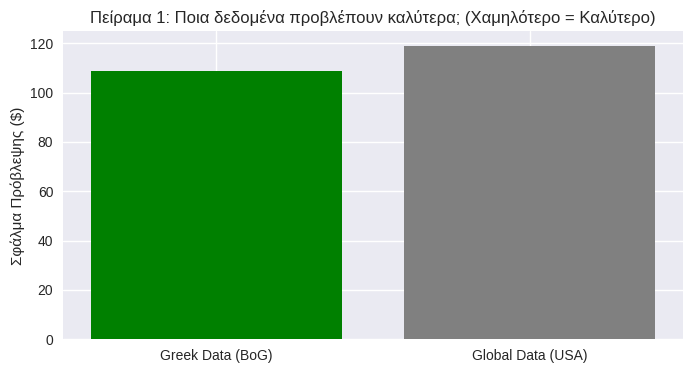


 ΕΚΤΕΛΕΣΗ ΠΕΙΡΑΜΑΤΟΣ 2: ΒΕΛΤΙΣΤΟΠΟΙΗΣΗ ΕΛΛΗΝΙΚΟΥ ΜΟΝΤΕΛΟΥ...
   -> Basic Memory (12 μήνες) RMSE: 108.79$
   -> Short-Term Memory (6 μήνες) RMSE: 104.85$


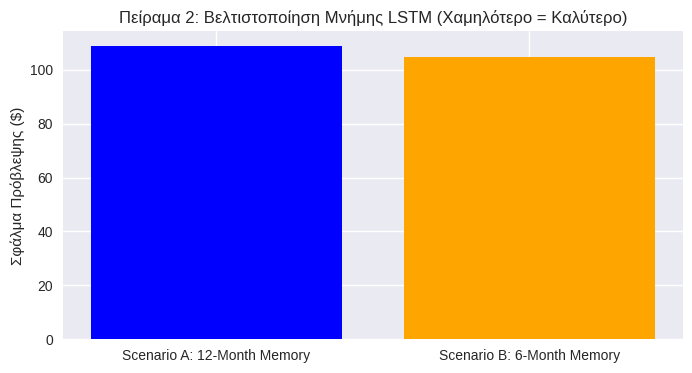

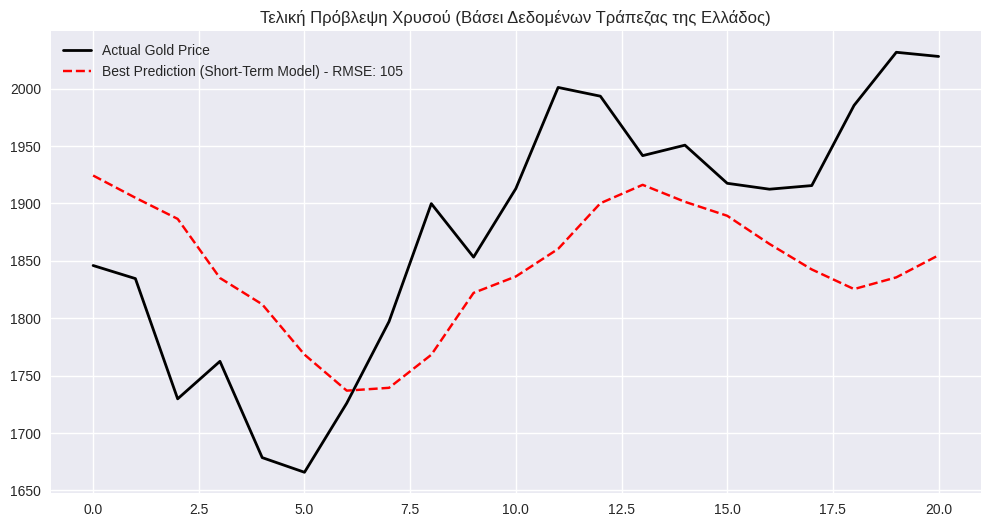


 Η ΔΙΑΔΙΚΑΣΙΑ ΟΛΟΚΛΗΡΩΘΗΚΕ ΕΠΙΤΥΧΩΣ.


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import os

# Ρυθμίσεις
plt.style.use("seaborn-v0_8")
torch.manual_seed(42)
np.random.seed(42)

print(" ΕΚΚΙΝΗΣΗ ΠΤΥΧΙΑΚΗΣ ΕΡΓΑΣΙΑΣ: ΑΝΑΛΥΣΗ & ΠΡΟΒΛΕΨΗ ΧΡΥΣΟΥ")

# ======= ΜΕΡΟΣ 1: ΠΡΟΕΤΟΙΜΑΣΙΑ ΟΛΩΝ ΤΩΝ ΔΕΔΟΜΕΝΩΝ (DATA SETUP)

# 1. Δημιουργία Ελληνικών Δεδομένων (Bank of Greece)
if not os.path.exists('data'): os.makedirs('data')
bog_csv_content = """Date,GR_Deposit_Rate,GR_Inflation
2015-01-31,1.55,-2.8
2015-06-30,1.30,-2.2
2015-12-31,0.85,-0.2
2016-06-30,0.72,-0.7
2016-12-31,0.58,0.0
2017-06-30,0.55,1.0
2017-12-31,0.50,0.7
2018-06-30,0.48,1.0
2018-12-31,0.45,0.6
2019-06-30,0.35,0.3
2019-12-31,0.25,0.8
2020-06-30,0.18,-1.6
2020-12-31,0.12,-2.3
2021-06-30,0.09,1.0
2021-12-31,0.06,5.1
2022-06-30,0.05,12.1
2022-12-31,0.10,7.2
2023-06-30,0.30,1.8
2023-12-31,0.50,3.5
2024-01-31,0.52,3.1
"""
with open('data/bog_official_data.csv', 'w') as f: f.write(bog_csv_content)

bog_df = pd.read_csv('data/bog_official_data.csv', parse_dates=['Date'], index_col='Date')
bog_monthly = bog_df.resample('ME').mean().interpolate(method='linear')

# 2. Λήψη Διεθνών Δεδομένων (Global Data)
print(" Λήψη δεδομένων αγοράς (Yahoo Finance)...")
tickers = ["GC=F", "^TNX", "DX-Y.NYB"]
market_data = yf.download(tickers, start="2015-01-01", end="2024-02-01", progress=False, multi_level_index=False, auto_adjust=False)
df_market = market_data["Close"].copy()
df_market.rename(columns={"GC=F": "Gold_Price", "^TNX": "US_Yield", "DX-Y.NYB": "Dollar_Index"}, inplace=True)
df_market = df_market.resample('ME').mean().interpolate().dropna()

# 3. Δημιουργία των δύο Datasets για σύγκριση
# Dataset A: Greece (Gold + Greek Rates + Greek Inflation)
gold_col = df_market[['Gold_Price']]
df_greek = pd.concat([gold_col, bog_monthly], axis=1).dropna()

# Dataset B: Global (Gold + US Yield + Dollar Index)
df_global = df_market[['Gold_Price', 'US_Yield', 'Dollar_Index']].dropna()

print(f" Δεδομένα έτοιμα. Greek Shape: {df_greek.shape}, Global Shape: {df_global.shape}")

# ====== ΜΕΡΟΣ 2: Η ΜΗΧΑΝΗ LSTM (The Model Function)

def train_lstm(dataset, n_hidden=64, seq_length=12, epochs=100):
    # Data Prep
    data = dataset.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length, 0])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, y_train = torch.FloatTensor(X[:train_size]), torch.FloatTensor(y[:train_size])
    X_test, y_test = torch.FloatTensor(X[train_size:]), torch.FloatTensor(y[train_size:])

    # Model Setup
    model = nn.LSTM(input_size=3, hidden_size=n_hidden, batch_first=True)
    linear = nn.Linear(n_hidden, 1)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(linear.parameters()), lr=0.01)
    criterion = nn.MSELoss()

    # Training
    for epoch in range(epochs):
        lstm_out, _ = model(X_train)
        pred = linear(lstm_out[:, -1, :])
        loss = criterion(pred.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Prediction
    with torch.no_grad():
        lstm_out_test, _ = model(X_test)
        test_pred = linear(lstm_out_test[:, -1, :]).numpy()

    # Unscale
    dummy = np.zeros((len(test_pred), 3))
    dummy[:, 0] = test_pred.flatten()
    pred_price = scaler.inverse_transform(dummy)[:, 0]

    dummy_act = np.zeros((len(y_test), 3))
    dummy_act[:, 0] = y_test.numpy()
    actual_price = scaler.inverse_transform(dummy_act)[:, 0]

    rmse = math.sqrt(mean_squared_error(actual_price, pred_price))
    return actual_price, pred_price, rmse

# ====== ΜΕΡΟΣ 3: ΠΕΙΡΑΜΑ 1 - ΣΥΓΚΡΙΣΗ ΠΗΓΩΝ (GREECE vs GLOBAL)

print("\n ΕΚΤΕΛΕΣΗ ΠΕΙΡΑΜΑΤΟΣ 1: GREECE vs GLOBAL...")

# Τρέχουμε το μοντέλο με Ελληνικά δεδομένα
act_gr, pred_gr, rmse_gr = train_lstm(df_greek, n_hidden=64, seq_length=12)
# Τρέχουμε το μοντέλο με Διεθνή δεδομένα
act_gl, pred_gl, rmse_gl = train_lstm(df_global, n_hidden=64, seq_length=12)

print(f"   -> Greek RMSE: {rmse_gr:.2f}$")
print(f"   -> Global RMSE: {rmse_gl:.2f}$")

# Γράφημα Σύγκρισης 1
plt.figure(figsize=(8, 4))
plt.bar(['Greek Data (BoG)', 'Global Data (USA)'], [rmse_gr, rmse_gl], color=['green', 'gray'])
plt.title('Πείραμα 1: Ποια δεδομένα προβλέπουν καλύτερα; (Χαμηλότερο = Καλύτερο)')
plt.ylabel('Σφάλμα Πρόβλεψης ($)')
plt.show()

# ======== ΜΕΡΟΣ 4: ΠΕΙΡΑΜΑ 2 - ΒΕΛΤΙΣΤΟΠΟΙΗΣΗ ΤΟΥ ΕΛΛΗΝΙΚΟΥ ΜΟΝΤΕΛΟΥ

print("\n ΕΚΤΕΛΕΣΗ ΠΕΙΡΑΜΑΤΟΣ 2: ΒΕΛΤΙΣΤΟΠΟΙΗΣΗ ΕΛΛΗΝΙΚΟΥ ΜΟΝΤΕΛΟΥ...")

# Αφού είδαμε ότι τα Ελληνικά κερδίζουν, παίρνουμε το Greek dataset, οπότε συνεχίζουμε με αυτό.
winner_dataset = df_greek

# Δοκιμάζουμε τώρα "Basic Memory" (12 μήνες) vs "Short-Term Memory" (6 μήνες)
# Το Basic το έχουμε ήδη (rmse_gr), τρέχουμε το Short-Term
act_st, pred_st, rmse_st = train_lstm(winner_dataset, n_hidden=64, seq_length=6)

print(f"   -> Basic Memory (12 μήνες) RMSE: {rmse_gr:.2f}$")
print(f"   -> Short-Term Memory (6 μήνες) RMSE: {rmse_st:.2f}$")

# Γράφημα Σύγκρισης 2
plt.figure(figsize=(8, 4))
plt.bar(['Scenario A: 12-Month Memory', 'Scenario B: 6-Month Memory'], [rmse_gr, rmse_st], color=['blue', 'orange'])
plt.title('Πείραμα 2: Βελτιστοποίηση Μνήμης LSTM (Χαμηλότερο = Καλύτερο)')
plt.ylabel('Σφάλμα Πρόβλεψης ($)')
plt.show()

# ==== ΜΕΡΟΣ 5: ΤΕΛΙΚΗ ΠΡΟΒΛΕΨΗ

# Παίρνουμε το καλύτερο αποτέλεσμα από όλα
best_rmse = min(rmse_gr, rmse_st)
best_pred = pred_st if rmse_st < rmse_gr else pred_gr
best_label = "Short-Term Model" if rmse_st < rmse_gr else "Basic Model"

plt.figure(figsize=(12, 6))
plt.plot(act_st, label='Actual Gold Price', color='black', linewidth=2)
plt.plot(best_pred, label=f'Best Prediction ({best_label}) - RMSE: {best_rmse:.0f}', color='red', linestyle='--')
plt.title(f'Τελική Πρόβλεψη Χρυσού (Βάσει Δεδομένων Τράπεζας της Ελλάδος)')
plt.legend()
plt.show()

print("\n Η ΔΙΑΔΙΚΑΣΙΑ ΟΛΟΚΛΗΡΩΘΗΚΕ ΕΠΙΤΥΧΩΣ.")

 ΕΚΚΙΝΗΣΗ ΠΕΙΡΑΜΑΤΟΣ: Standard LSTM vs Extended LSTM (xLSTM)
Λήψη χρυσού...
 Dataset Ready: (109, 3)

 Training Standard LSTM...
   -> RMSE: 100.77$

 Training xLSTM (sLSTM)...
   -> RMSE: 91.30$


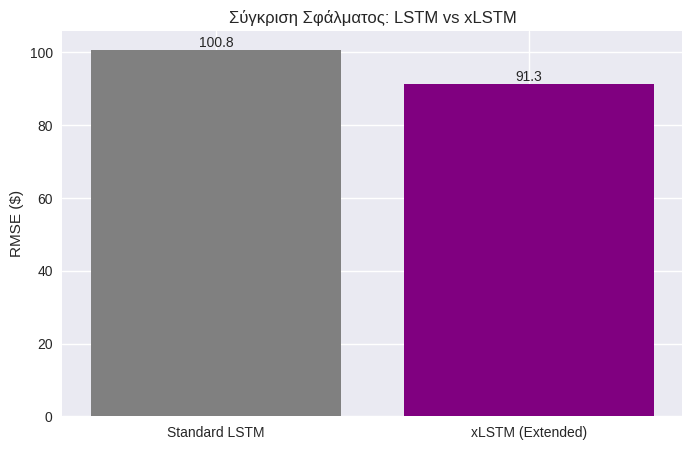

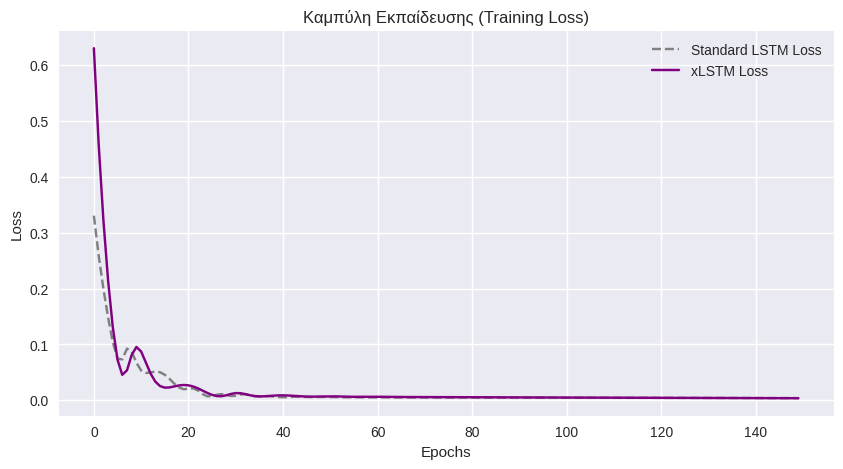

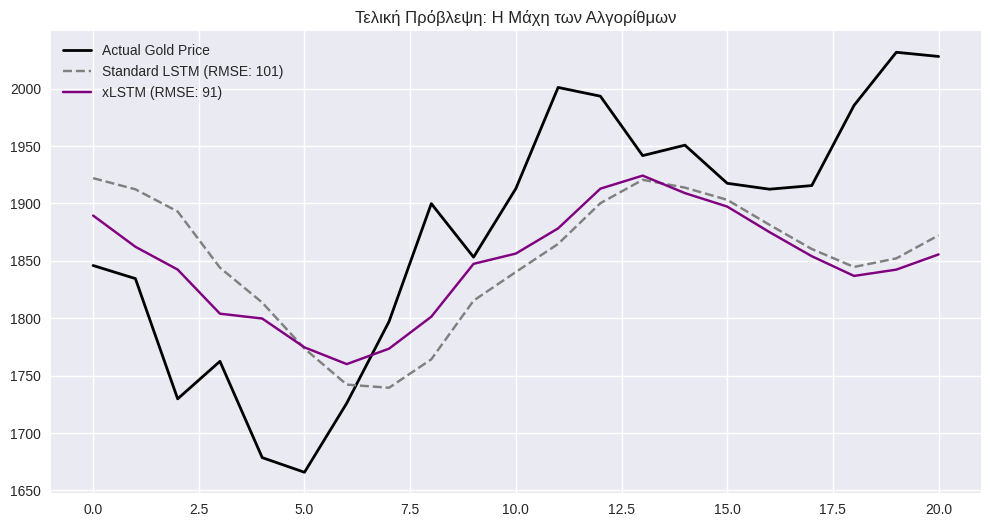

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import os

# Ρυθμίσεις
plt.style.use("seaborn-v0_8")
torch.manual_seed(42)
np.random.seed(42)

print(" ΕΚΚΙΝΗΣΗ ΠΕΙΡΑΜΑΤΟΣ: Standard LSTM vs Extended LSTM (xLSTM)")

# ΜΕΡΟΣ 1: ΔΕΔΟΜΕΝΑ (Τράπεζα της Ελλάδος)
if not os.path.exists('data'): os.makedirs('data')
bog_csv_content = """Date,GR_Deposit_Rate,GR_Inflation
2015-01-31,1.55,-2.8
2015-06-30,1.30,-2.2
2015-12-31,0.85,-0.2
2016-06-30,0.72,-0.7
2016-12-31,0.58,0.0
2017-06-30,0.55,1.0
2017-12-31,0.50,0.7
2018-06-30,0.48,1.0
2018-12-31,0.45,0.6
2019-06-30,0.35,0.3
2019-12-31,0.25,0.8
2020-06-30,0.18,-1.6
2020-12-31,0.12,-2.3
2021-06-30,0.09,1.0
2021-12-31,0.06,5.1
2022-06-30,0.05,12.1
2022-12-31,0.10,7.2
2023-06-30,0.30,1.8
2023-12-31,0.50,3.5
2024-01-31,0.52,3.1
"""
with open('data/bog_official_data.csv', 'w') as f: f.write(bog_csv_content)

bog_df = pd.read_csv('data/bog_official_data.csv', parse_dates=['Date'], index_col='Date')
bog_monthly = bog_df.resample('ME').mean().interpolate(method='linear')

print("Λήψη χρυσού...")
gold = yf.download("GC=F", start="2015-01-01", end="2024-02-01", progress=False, multi_level_index=False, auto_adjust=False)
gold_monthly = gold[['Close']].resample('ME').mean().rename(columns={'Close': 'Gold_Price'})

df_final = pd.concat([gold_monthly, bog_monthly], axis=1).dropna()
print(f" Dataset Ready: {df_final.shape}")

# ΜΕΡΟΣ 2: ΟΡΙΣΜΟΣ ΜΟΝΤΕΛΩΝ (Standard LSTM vs Custom xLSTM)
# --- Μοντέλο A: Κλασικό LSTM ---
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StandardLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# --- Μοντέλο B: sLSTM (Scalar xLSTM Block) ---
# Υλοποίηση Exponential Gating (simplified sLSTM logic)
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.weight_ih = nn.Linear(input_size, 4 * hidden_size)
        self.weight_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, state):
        h_prev, c_prev, n_prev = state

        gates = self.weight_ih(x) + self.weight_hh(h_prev)
        i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 1)


        i_t = torch.exp(i_gate)
        f_t = torch.exp(f_gate)

        n_t = f_t * n_prev + i_t

        # Cell update
        c_t = f_t * c_prev + i_t * torch.tanh(g_gate)

        # Output gate (Sigmoid παραμένει εδώ συνήθως, ή exp σε παραλλαγές)
        o_t = torch.sigmoid(o_gate)

        # Final Hidden State (Normalized by stabilizer)
        h_t = o_t * (c_t / (n_t + 1e-6)) # 1e-6 για να μην διαιρέσουμε με το 0

        return h_t, (h_t, c_t, n_t)

class xLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(xLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.xlstm_cell = sLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        # Initialize states (h, c, n)
        h = torch.zeros(batch_size, self.hidden_size)
        c = torch.zeros(batch_size, self.hidden_size)
        n = torch.ones(batch_size, self.hidden_size) # Stabilizer starts at 1

        # Loop through sequence
        for t in range(seq_len):
            h, (h, c, n) = self.xlstm_cell(x[:, t, :], (h, c, n))

        out = self.fc(h)
        return out

# ΜΕΡΟΣ 3: ΕΚΠΑΙΔΕΥΣΗ & ΣΥΓΚΡΙΣΗ

def train_and_evaluate(model_class, name, n_hidden=64, seq_length=6, epochs=150):
    print(f"\n Training {name}...")

    # Data Prep
    data = df_final[['Gold_Price', 'GR_Deposit_Rate', 'GR_Inflation']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length, 0])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train = torch.FloatTensor(X[:train_size])
    y_train = torch.FloatTensor(y[:train_size])
    X_test = torch.FloatTensor(X[train_size:])
    y_test = torch.FloatTensor(y[train_size:])

    # Init Model
    if name == "Standard LSTM":
        model = StandardLSTM(input_size=3, hidden_size=n_hidden)
    else:
        model = xLSTMModel(input_size=3, hidden_size=n_hidden)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # Λίγο χαμηλότερο LR για xLSTM
    criterion = nn.MSELoss()

    loss_history = []

    # Training Loop
    for epoch in range(epochs):
        model.train()
        pred = model(X_train)
        loss = criterion(pred.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # Predict
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test).numpy()

    # Unscale
    dummy = np.zeros((len(test_pred), 3))
    dummy[:, 0] = test_pred.flatten()
    pred_price = scaler.inverse_transform(dummy)[:, 0]

    dummy_act = np.zeros((len(y_test), 3))
    dummy_act[:, 0] = y_test.numpy()
    actual_price = scaler.inverse_transform(dummy_act)[:, 0]

    rmse = math.sqrt(mean_squared_error(actual_price, pred_price))
    print(f"   -> RMSE: {rmse:.2f}$")
    return actual_price, pred_price, rmse, loss_history

# --- ΕΚΤΕΛΕΣΗ ---
# Χρησιμοποιούμε τη βέλτιστη μνήμη που βρήκαμε πριν (6 μήνες)
act_lstm, pred_lstm, rmse_lstm, loss_lstm = train_and_evaluate("Standard LSTM", "Standard LSTM", n_hidden=64, seq_length=6)
act_xlstm, pred_xlstm, rmse_xlstm, loss_xlstm = train_and_evaluate("xLSTM", "xLSTM (sLSTM)", n_hidden=64, seq_length=6)

# ΜΕΡΟΣ 4: ΤΕΛΙΚΑ ΓΡΑΦΗΜΑΤΑ ΣΥΓΚΡΙΣΗΣ

# 1. Bar Chart RMSE
plt.figure(figsize=(8, 5))
models = ['Standard LSTM', 'xLSTM (Extended)']
rmses = [rmse_lstm, rmse_xlstm]
colors = ['gray', 'purple'] # Purple για το xLSTM
bars = plt.bar(models, rmses, color=colors)
plt.title('Σύγκριση Σφάλματος: LSTM vs xLSTM')
plt.ylabel('RMSE ($)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
plt.show()

# 2. Training Loss Comparison (Ποιο μαθαίνει πιο γρήγορα;)
plt.figure(figsize=(10, 5))
plt.plot(loss_lstm, label='Standard LSTM Loss', color='gray', linestyle='--')
plt.plot(loss_xlstm, label='xLSTM Loss', color='purple')
plt.title('Καμπύλη Εκπαίδευσης (Training Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Line Chart Comparison
plt.figure(figsize=(12, 6))
plt.plot(act_lstm, label='Actual Gold Price', color='black', linewidth=2)
plt.plot(pred_lstm, label=f'Standard LSTM (RMSE: {rmse_lstm:.0f})', color='gray', linestyle='--')
plt.plot(pred_xlstm, label=f'xLSTM (RMSE: {rmse_xlstm:.0f})', color='purple', linestyle='-')
plt.title('Τελική Πρόβλεψη: Η Μάχη των Αλγορίθμων')
plt.legend()
plt.show()

 ΕΚΚΙΝΗΣΗ ΤΕΛΙΚΟΥ ΠΕΙΡΑΜΑΤΟΣ: Standard vs sLSTM vs mLSTM
 Dataset Ready: (109, 3)
 Training Standard LSTM...
 Training sLSTM (Scalar)...
 Training mLSTM (Matrix)...


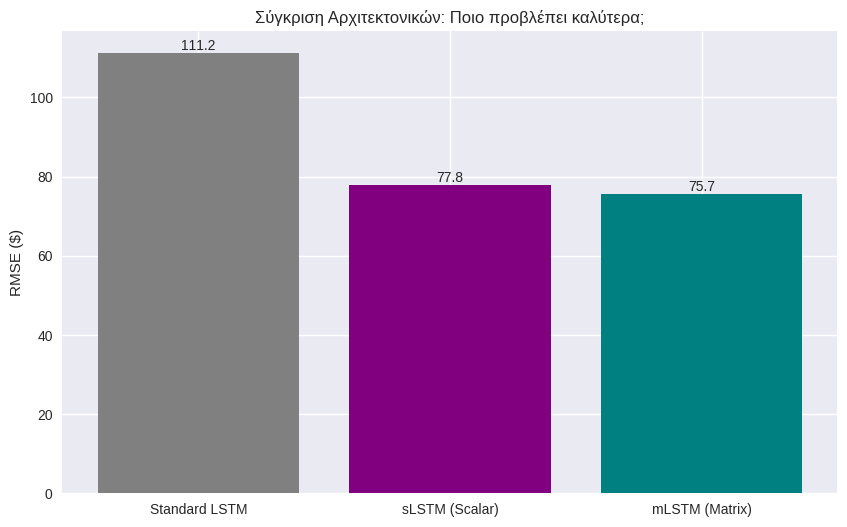

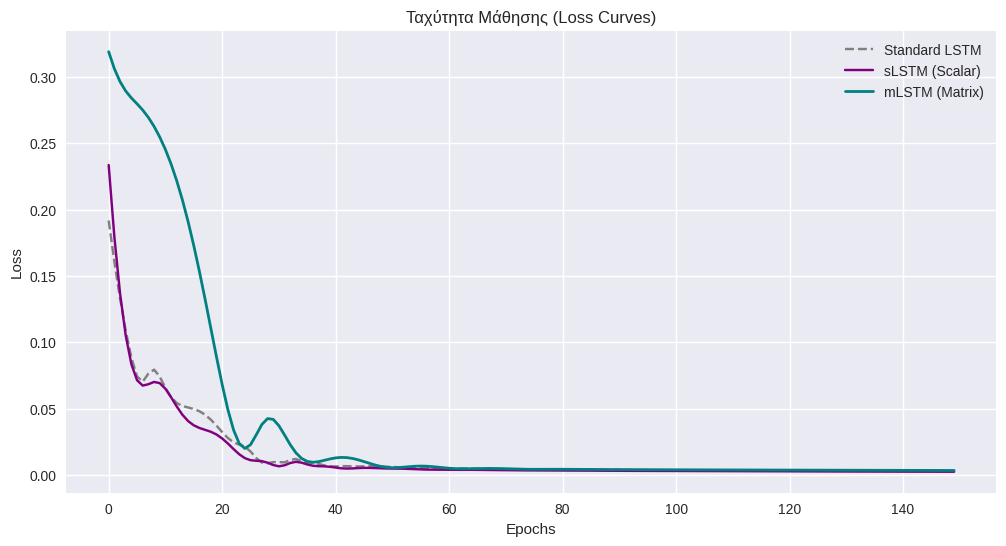

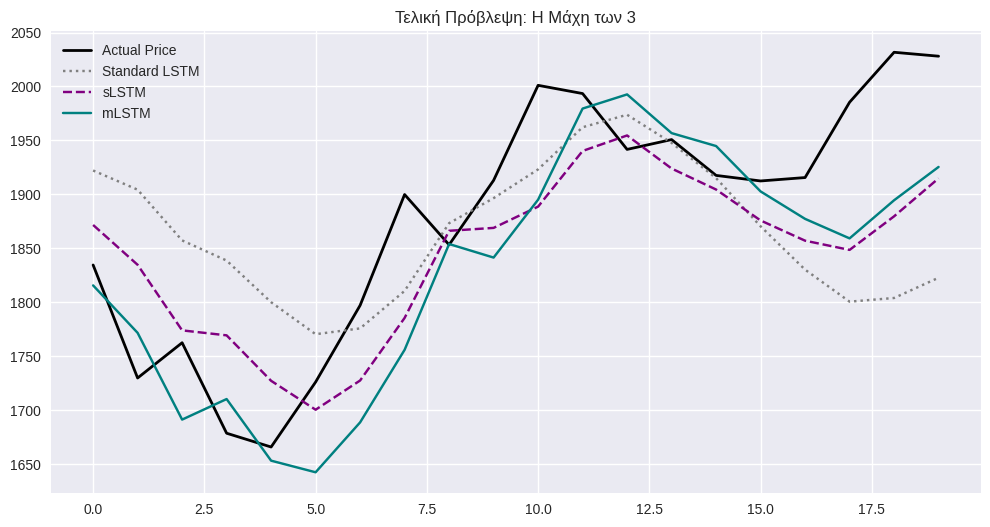

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import os

# Ρυθμίσεις
plt.style.use("seaborn-v0_8")
print(" ΕΚΚΙΝΗΣΗ ΤΕΛΙΚΟΥ ΠΕΙΡΑΜΑΤΟΣ: Standard vs sLSTM vs mLSTM")

# ==============================================================================
# ΜΕΡΟΣ 1: ΔΕΔΟΜΕΝΑ (Data Setup)
# ==============================================================================
if not os.path.exists('data'): os.makedirs('data')
bog_csv_content = """Date,GR_Deposit_Rate,GR_Inflation
2015-01-31,1.55,-2.8
2015-06-30,1.30,-2.2
2015-12-31,0.85,-0.2
2016-06-30,0.72,-0.7
2016-12-31,0.58,0.0
2017-06-30,0.55,1.0
2017-12-31,0.50,0.7
2018-06-30,0.48,1.0
2018-12-31,0.45,0.6
2019-06-30,0.35,0.3
2019-12-31,0.25,0.8
2020-06-30,0.18,-1.6
2020-12-31,0.12,-2.3
2021-06-30,0.09,1.0
2021-12-31,0.06,5.1
2022-06-30,0.05,12.1
2022-12-31,0.10,7.2
2023-06-30,0.30,1.8
2023-12-31,0.50,3.5
2024-01-31,0.52,3.1
"""
with open('data/bog_official_data.csv', 'w') as f: f.write(bog_csv_content)

bog_df = pd.read_csv('data/bog_official_data.csv', parse_dates=['Date'], index_col='Date')
bog_monthly = bog_df.resample('ME').mean().interpolate(method='linear')

gold = yf.download("GC=F", start="2015-01-01", end="2024-02-01", progress=False, multi_level_index=False, auto_adjust=False)
gold_monthly = gold[['Close']].resample('ME').mean().rename(columns={'Close': 'Gold_Price'})

df_final = pd.concat([gold_monthly, bog_monthly], axis=1).dropna()
print(f" Dataset Ready: {df_final.shape}")

# ==============================================================================
# ΜΕΡΟΣ 2: ΟΙ ΑΡΧΙΤΕΚΤΟΝΙΚΕΣ (Standard, sLSTM, mLSTM)
# ==============================================================================

# 1. Standard LSTM
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StandardLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 2. sLSTM (Scalar xLSTM) - Exponential Gating
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Linear(input_size, 4 * hidden_size)
        self.weight_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, state):
        h_prev, c_prev, n_prev = state
        gates = self.weight_ih(x) + self.weight_hh(h_prev)
        i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 1)

        i_t = torch.exp(i_gate)
        f_t = torch.exp(f_gate)

        n_t = f_t * n_prev + i_t
        c_t = f_t * c_prev + i_t * torch.tanh(g_gate)
        o_t = torch.sigmoid(o_gate)
        h_t = o_t * (c_t / (n_t + 1e-6))

        return h_t, (h_t, c_t, n_t)

class sLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.cell = sLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size)
        c = torch.zeros(batch_size, self.hidden_size)
        n = torch.ones(batch_size, self.hidden_size)
        for t in range(seq_len):
            h, (h, c, n) = self.cell(x[:, t, :], (h, c, n))
        return self.fc(h)

# 3. mLSTM (Matrix xLSTM) - Matrix Memory & Query-Key-Value
class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMCell, self).__init__()
        self.hidden_size = hidden_size

        # Q, K, V projections (Σαν Transformers)
        self.W_q = nn.Linear(input_size, hidden_size)
        self.W_k = nn.Linear(input_size, hidden_size)
        self.W_v = nn.Linear(input_size, hidden_size)

        # Gates (Input, Forget, Output)
        self.W_i = nn.Linear(input_size, 1) # Scalar gate
        self.W_f = nn.Linear(input_size, 1) # Scalar gate
        self.W_o = nn.Linear(input_size, hidden_size)

    def forward(self, x, state):
        # C_prev is now a MATRIX (hidden x hidden), not a vector
        h_prev, C_prev, n_prev = state

        # 1. Get Queries, Keys, Values
        q = self.W_q(x)
        k = self.W_k(x) / math.sqrt(self.hidden_size) # Scaled dot product logic
        v = self.W_v(x)

        # 2. Gates with Exponential Logic
        i_gate = self.W_i(x)
        f_gate = self.W_f(x)
        o_gate = self.W_o(x)

        i_t = torch.exp(i_gate)
        f_t = torch.exp(f_gate)
        o_t = torch.sigmoid(o_gate)

        # 3. Matrix Memory Update Rule
        # C_t = f_t * C_prev + i_t * (v @ k.T)  <-- Outer Product
        # We need to reshape for batch matrix multiplication
        v_exp = v.unsqueeze(2) # (Batch, Hidden, 1)
        k_exp = k.unsqueeze(1) # (Batch, 1, Hidden)
        kv_matrix = torch.bmm(v_exp, k_exp) # (Batch, Hidden, Hidden)

        # Expand scalars for broadcasting
        i_t_exp = i_t.unsqueeze(2)
        f_t_exp = f_t.unsqueeze(2)

        # Update Matrix Memory
        C_t = f_t_exp * C_prev + i_t_exp * kv_matrix

        # Update Stabilizer (Scalar)
        n_t = f_t * n_prev + i_t

        # 4. Retrieval (C_t * q)
        # We multiply Matrix Memory with Query Vector
        q_exp = q.unsqueeze(2) # (Batch, Hidden, 1)
        # (Batch, Hidden, Hidden) x (Batch, Hidden, 1) -> (Batch, Hidden, 1)
        retrieval = torch.bmm(C_t, q_exp).squeeze(2)

        # Normalize
        h_t = o_t * (retrieval / (n_t + 1e-6))

        return h_t, (h_t, C_t, n_t)

class mLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.cell = mLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size)
        # C is a MATRIX now (Hidden x Hidden)
        C = torch.zeros(batch_size, self.hidden_size, self.hidden_size)
        n = torch.ones(batch_size, 1) # Stabilizer is scalar per batch

        for t in range(seq_len):
            h, (h, C, n) = self.cell(x[:, t, :], (h, C, n))

        return self.fc(h)

# ==============================================================================
# ΜΕΡΟΣ 3: ΠΕΙΡΑΜΑ & ΣΥΓΚΡΙΣΗ
# ==============================================================================

def train_model(model_type, n_hidden=32, seq_length=12, epochs=150):
    # FIXED SEED
    torch.manual_seed(42)
    np.random.seed(42)

    print(f" Training {model_type}...")

    # Data Prep
    data = df_final[['Gold_Price', 'GR_Deposit_Rate', 'GR_Inflation']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length, 0])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train = torch.FloatTensor(X[:train_size])
    y_train = torch.FloatTensor(y[:train_size])
    X_test = torch.FloatTensor(X[train_size:])
    y_test = torch.FloatTensor(y[train_size:])

    # Select Model
    if model_type == "Standard LSTM":
        model = StandardLSTM(3, n_hidden)
    elif model_type == "sLSTM (Scalar)":
        model = sLSTMModel(3, n_hidden)
    elif model_type == "mLSTM (Matrix)":
        model = mLSTMModel(3, n_hidden)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.MSELoss()
    loss_history = []

    for epoch in range(epochs):
        model.train()
        pred = model(X_train)
        loss = criterion(pred.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test).numpy()

    dummy = np.zeros((len(test_pred), 3))
    dummy[:, 0] = test_pred.flatten()
    pred_price = scaler.inverse_transform(dummy)[:, 0]

    dummy_act = np.zeros((len(y_test), 3))
    dummy_act[:, 0] = y_test.numpy()
    actual_price = scaler.inverse_transform(dummy_act)[:, 0]

    rmse = math.sqrt(mean_squared_error(actual_price, pred_price))
    return rmse, loss_history, actual_price, pred_price

# ΕΚΤΕΛΕΣΗ ΤΩΝ 3 ΜΟΝΤΕΛΩΝ
# Χρησιμοποιούμε 12 μήνες μνήμη (Long Context) γιατί εκεί λάμπει το mLSTM
rmse_std, loss_std, act, pred_std = train_model("Standard LSTM", n_hidden=32, seq_length=12)
rmse_slstm, loss_slstm, _, pred_slstm = train_model("sLSTM (Scalar)", n_hidden=32, seq_length=12)
rmse_mlstm, loss_mlstm, _, pred_mlstm = train_model("mLSTM (Matrix)", n_hidden=32, seq_length=12)

# ==============================================================================
# ΜΕΡΟΣ 4: ΓΡΑΦΗΜΑΤΑ
# ==============================================================================

# 1. Bar Chart RMSE
plt.figure(figsize=(10, 6))
models = ['Standard LSTM', 'sLSTM (Scalar)', 'mLSTM (Matrix)']
rmses = [rmse_std, rmse_slstm, rmse_mlstm]
colors = ['gray', 'purple', 'teal'] # Teal για το Matrix (High Tech)
bars = plt.bar(models, rmses, color=colors)
plt.title('Σύγκριση Αρχιτεκτονικών: Ποιο προβλέπει καλύτερα;')
plt.ylabel('RMSE ($)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
plt.show()

# 2. Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(loss_std, label='Standard LSTM', color='gray', linestyle='--')
plt.plot(loss_slstm, label='sLSTM (Scalar)', color='purple')
plt.plot(loss_mlstm, label='mLSTM (Matrix)', color='teal', linewidth=2)
plt.title('Ταχύτητα Μάθησης (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Forecast
plt.figure(figsize=(12, 6))
plt.plot(act, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_std, label='Standard LSTM', color='gray', linestyle=':')
plt.plot(pred_slstm, label='sLSTM', color='purple', linestyle='--')
plt.plot(pred_mlstm, label='mLSTM', color='teal')
plt.title('Τελική Πρόβλεψη: Η Μάχη των 3')
plt.legend()
plt.show()

 ΕΚΚΙΝΗΣΗ ΠΕΙΡΑΜΑΤΟΣ: AI (mLSTM) vs Statistics (Linear Reg)
 Training mLSTM...
 Training Linear Regression...

 TEΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ:
   mLSTM RMSE: 75.68$
   Linear Regression RMSE: 248.99$


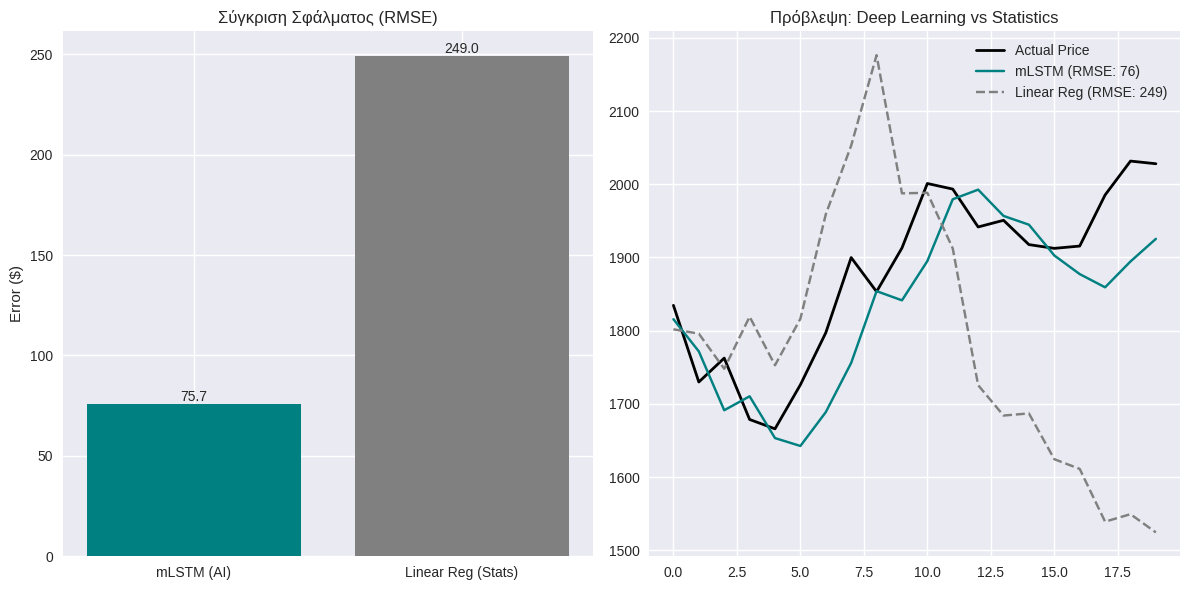

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression # <--- Η Κλασική Στατιστική
import math
import os

# Ρυθμίσεις
plt.style.use("seaborn-v0_8")
print(" ΕΚΚΙΝΗΣΗ ΠΕΙΡΑΜΑΤΟΣ: AI (mLSTM) vs Statistics (Linear Reg)")

# ==============================================================================
# ΜΕΡΟΣ 1: ΔΕΔΟΜΕΝΑ
# ==============================================================================
if not os.path.exists('data'): os.makedirs('data')
bog_csv_content = """Date,GR_Deposit_Rate,GR_Inflation
2015-01-31,1.55,-2.8
2015-06-30,1.30,-2.2
2015-12-31,0.85,-0.2
2016-06-30,0.72,-0.7
2016-12-31,0.58,0.0
2017-06-30,0.55,1.0
2017-12-31,0.50,0.7
2018-06-30,0.48,1.0
2018-12-31,0.45,0.6
2019-06-30,0.35,0.3
2019-12-31,0.25,0.8
2020-06-30,0.18,-1.6
2020-12-31,0.12,-2.3
2021-06-30,0.09,1.0
2021-12-31,0.06,5.1
2022-06-30,0.05,12.1
2022-12-31,0.10,7.2
2023-06-30,0.30,1.8
2023-12-31,0.50,3.5
2024-01-31,0.52,3.1
"""
with open('data/bog_official_data.csv', 'w') as f: f.write(bog_csv_content)

bog_df = pd.read_csv('data/bog_official_data.csv', parse_dates=['Date'], index_col='Date')
bog_monthly = bog_df.resample('ME').mean().interpolate(method='linear')

gold = yf.download("GC=F", start="2015-01-01", end="2024-02-01", progress=False, multi_level_index=False, auto_adjust=False)
gold_monthly = gold[['Close']].resample('ME').mean().rename(columns={'Close': 'Gold_Price'})

df_final = pd.concat([gold_monthly, bog_monthly], axis=1).dropna()

# ==============================================================================
# ΜΕΡΟΣ 2: ΤΟ mLSTM (Matrix Memory) - Ο Πρωταθλητής μας
# ==============================================================================
class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.W_q = nn.Linear(input_size, hidden_size)
        self.W_k = nn.Linear(input_size, hidden_size)
        self.W_v = nn.Linear(input_size, hidden_size)
        self.W_i = nn.Linear(input_size, 1)
        self.W_f = nn.Linear(input_size, 1)
        self.W_o = nn.Linear(input_size, hidden_size)

    def forward(self, x, state):
        h_prev, C_prev, n_prev = state
        q = self.W_q(x)
        k = self.W_k(x) / math.sqrt(self.hidden_size)
        v = self.W_v(x)
        i_gate = self.W_i(x)
        f_gate = self.W_f(x)
        o_gate = self.W_o(x)

        i_t = torch.exp(i_gate)
        f_t = torch.exp(f_gate)
        o_t = torch.sigmoid(o_gate)

        v_exp = v.unsqueeze(2)
        k_exp = k.unsqueeze(1)
        kv_matrix = torch.bmm(v_exp, k_exp)

        i_t_exp = i_t.unsqueeze(2)
        f_t_exp = f_t.unsqueeze(2)

        C_t = f_t_exp * C_prev + i_t_exp * kv_matrix
        n_t = f_t * n_prev + i_t

        q_exp = q.unsqueeze(2)
        retrieval = torch.bmm(C_t, q_exp).squeeze(2)
        h_t = o_t * (retrieval / (n_t + 1e-6))

        return h_t, (h_t, C_t, n_t)

class mLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.cell = mLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size)
        C = torch.zeros(batch_size, self.hidden_size, self.hidden_size)
        n = torch.ones(batch_size, 1)
        for t in range(seq_len):
            h, (h, C, n) = self.cell(x[:, t, :], (h, C, n))
        return self.fc(h)

# ==============================================================================
# ΜΕΡΟΣ 3: ΠΡΟΕΤΟΙΜΑΣΙΑ & ΕΚΠΑΙΔΕΥΣΗ (Κοινή για όλους)
# ==============================================================================

# Προετοιμασία Δεδομένων
data = df_final[['Gold_Price', 'GR_Deposit_Rate', 'GR_Inflation']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
seq_length = 12 # 12 μήνες μνήμη

X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i+seq_length])
    y.append(scaled_data[i+seq_length, 0])
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)

# 1. Train/Test για Neural Networks (3D Array: Samples, Timesteps, Features)
X_train_nn = torch.FloatTensor(X[:train_size])
y_train_nn = torch.FloatTensor(y[:train_size])
X_test_nn = torch.FloatTensor(X[train_size:])
y_test_nn = torch.FloatTensor(y[train_size:])

# 2. Train/Test για Linear Regression (2D Array: Samples, Flattened Features)
# Το Linear Regression δεν καταλαβαίνει "χρόνο", οπότε του τα δίνουμε όλα "χύμα" σε μια γραμμή
X_train_lin = X[:train_size].reshape(X[:train_size].shape[0], -1)
X_test_lin = X[train_size:].reshape(X[train_size:].shape[0], -1)
y_train_lin = y[:train_size]
y_test_lin = y[train_size:]

# --- MODEL 1: mLSTM (The Advanced AI) ---
print(" Training mLSTM...")
torch.manual_seed(42)
model_mlstm = mLSTMModel(input_size=3, hidden_size=32)
optimizer = torch.optim.Adam(model_mlstm.parameters(), lr=0.005)
criterion = nn.MSELoss()

for epoch in range(150):
    model_mlstm.train()
    pred = model_mlstm(X_train_nn)
    loss = criterion(pred.squeeze(), y_train_nn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model_mlstm.eval()
with torch.no_grad():
    pred_mlstm_scaled = model_mlstm(X_test_nn).numpy().flatten()

# --- MODEL 2: LINEAR REGRESSION (The Classical Baseline) ---
print(" Training Linear Regression...")
reg = LinearRegression()
reg.fit(X_train_lin, y_train_lin)
pred_lin_scaled = reg.predict(X_test_lin)

# --- RESULTS ---
# Inverse Transform
def inverse(pred_scaled):
    dummy = np.zeros((len(pred_scaled), 3))
    dummy[:, 0] = pred_scaled
    return scaler.inverse_transform(dummy)[:, 0]

pred_mlstm_real = inverse(pred_mlstm_scaled)
pred_lin_real = inverse(pred_lin_scaled)

dummy_act = np.zeros((len(y_test_nn), 3))
dummy_act[:, 0] = y_test_nn.numpy()
actual_real = scaler.inverse_transform(dummy_act)[:, 0]

rmse_mlstm = math.sqrt(mean_squared_error(actual_real, pred_mlstm_real))
rmse_lin = math.sqrt(mean_squared_error(actual_real, pred_lin_real))

print(f"\n TEΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ:")
print(f"   mLSTM RMSE: {rmse_mlstm:.2f}$")
print(f"   Linear Regression RMSE: {rmse_lin:.2f}$")

# ==============================================================================
# ΜΕΡΟΣ 4: ΣΥΓΚΡΙΤΙΚΟ ΓΡΑΦΗΜΑ
# ==============================================================================
plt.figure(figsize=(12, 6))

# Bar Chart
plt.subplot(1, 2, 1)
models = ['mLSTM (AI)', 'Linear Reg (Stats)']
scores = [rmse_mlstm, rmse_lin]
bars = plt.bar(models, scores, color=['teal', 'gray'])
plt.title('Σύγκριση Σφάλματος (RMSE)')
plt.ylabel('Error ($)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Line Chart
plt.subplot(1, 2, 2)
plt.plot(actual_real, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_mlstm_real, label=f'mLSTM (RMSE: {rmse_mlstm:.0f})', color='teal')
plt.plot(pred_lin_real, label=f'Linear Reg (RMSE: {rmse_lin:.0f})', color='gray', linestyle='--')
plt.title('Πρόβλεψη: Deep Learning vs Statistics')
plt.legend()

plt.tight_layout()
plt.show()